In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.rnn import Bidirectional
from keras.layers.merging import add
from keras.applications.inception_v3 import InceptionV3
from keras.utils.image_utils import load_img, img_to_array
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from typing import List

In [3]:
# load doc into memory
def load_doc(filename) -> str:
    # Opening file for read only
    file1 = open(filename, 'r')
    # read all text
    text = file1.read()
    # close the file
    file1.close()
    return text

filename = r"/content/drive/MyDrive/Aditya/data/Flickr8k_text/Flickr8k.token.txt"
# load descriptions
doc = load_doc(filename)
print(doc[:41372])


1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg#0	A black dog and a spotted dog are fighting
1001773457_577c3a7d70.jpg#1	A black dog and a tri-colored dog playing with each other on the road .
1001773457_577c3a7d70.jpg#2	A black dog and a white dog with brown spots are staring at each other in the street .
1001773457_577c3a7d70.jpg#3	Two dogs of different breeds looking at each other on the road .
1001773457_577c3a7d70.jpg#4	Two dogs on pavement moving toward each other .
1002674143_1b742ab4b8.jpg#0	A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .
1002674143_1b

In [4]:
#Loading descriptions with above doc file
def load_descriptions(doc) -> dict:
    mapping = dict()
    # process lines
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        if len(line) < 2:
            continue
            # take the first token as the image id, the rest as the description
        image_id, image_desc = tokens[0], tokens[1:]
        # extract filename from image id
        image_id = image_id.split('.')[0]
        # convert description tokens back to string
        image_desc = ' '.join(image_desc)
        # create the list if needed
        if image_id not in mapping:
            mapping[image_id] = list()
            # store description
        mapping[image_id].append(image_desc)
    return mapping

# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


In [5]:
next(iter((descriptions.items())))

('1000268201_693b08cb0e',
 ['A child in a pink dress is climbing up a set of stairs in an entry way .',
  'A girl going into a wooden building .',
  'A little girl climbing into a wooden playhouse .',
  'A little girl climbing the stairs to her playhouse .',
  'A little girl in a pink dress going into a wooden cabin .'])

In [6]:
# Cleaning above descriptions
def clean_descriptions(descriptions) -> dict:
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)

# Cleaning the captions

In [7]:
# Checking here after cleaning how's it look like
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [8]:
# converting those loaded description into vocabulary of words
def to_vocabulary(descriptions) -> set:
    # build a list of all description strings
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

# saving the vocabulary in set

Original Vocabulary Size: 8763


In [9]:
# We are saving descriptions one per line
def save_descriptions(descriptions, filename) -> None:
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file1 = open(filename, 'w')
    file1.write(data)
    file1.close()

save_descriptions(descriptions, '/content/drive/MyDrive/Aditya/data/descriptions.txt')

# saving the description file

In [10]:
# loading  the pre-defined list of photo identifiers
def load_set(filename) -> set:
    doc = load_doc(filename)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # get the image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

# load training dataset (6K)
filename = r'/content/drive/MyDrive/Aditya/data/Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
#print('Dataset: %d' % len(train))
print(train)

# getting only the train image names in set

{'2247138288_7355861203', '2937497894_e3664a9513', '2540757246_5a849fbdcb', '2275372714_017c269742', '2986671935_0c60bbb3fa', '2741380826_cfe0ddf0a9', '3527715826_ea5b4e8de4', '3178371973_60c6b8f110', '610590753_cd69ce081a', '543326592_70bd4d8602', '2584020755_14e2b3e8fc', '3258395783_2de3a4ba27', '2865564810_5c63328cd4', '3351596152_bf283f03d1', '411863595_d77156687e', '407678652_1f475acd65', '3176072448_b84c99cf7f', '2228167286_7089ab236a', '482830610_13a0a6c924', '2720985888_8f5920e8cf', '3252588185_3210fe94be', '3615730936_23457575e9', '241346434_0527ea1c07', '2677614492_792023b928', '401476986_73918145a3', '1055623002_8195a43714', '2432038587_5e4148e277', '272940778_a184dbea42', '110595925_f3395c8bd6', '1252787177_4b08625897', '1285067106_2adc307240', '2748435417_ea7bbcc17c', '3306212559_731ba9bd05', '3724759125_2dc0e1f4a3', '3677613006_4689cb8e4e', '2981372647_2061278c60', '1119463452_69d4eecd08', '498492764_fe276e505a', '1432342377_3e41603f26', '3282897060_8c584e2ce8', '12369513

In [11]:
# Below path contains all the images
images = r'/content/drive/MyDrive/Aditya/data/Flicker8k_Dataset/'
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')

In [12]:
# Below path contains all name of images which is to be used as train data
train_images_file = r'/content/drive/MyDrive/Aditya/data/Flickr8k_text/Flickr_8k.trainImages.txt'
# Reading the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train image

# Checking the train images are present in the dataset or not and returning the full path of the images which are present
# train images = 6000

In [13]:
# Below path contains all name of images which is used to be as test data
test_images_file = r'/content/drive/MyDrive/Aditya/data/Flickr8k_text/Flickr_8k.testImages.txt'
# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

# Checking the test images are present in the dataset or not and returning the full path of the images which are present
# test images = 1000

In [14]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset) -> dict:
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# descriptions
descriptions_path = r"/content/drive/MyDrive/Aditya/data/descriptions.txt"
train_descriptions = load_clean_descriptions(descriptions_path, train)
print('Descriptions: train=%d' % len(train_descriptions))

# loading train image names with cleaned description

Descriptions: train=6000


In [15]:
train_descriptions

{'1000268201_693b08cb0e': ['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
  'startseq girl going into wooden building endseq',
  'startseq little girl climbing into wooden playhouse endseq',
  'startseq little girl climbing the stairs to her playhouse endseq',
  'startseq little girl in pink dress going into wooden cabin endseq'],
 '1001773457_577c3a7d70': ['startseq black dog and spotted dog are fighting endseq',
  'startseq black dog and tricolored dog playing with each other on the road endseq',
  'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
  'startseq two dogs of different breeds looking at each other on the road endseq',
  'startseq two dogs on pavement moving toward each other endseq'],
 '1002674143_1b742ab4b8': ['startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq',
  'startseq little girl is sitting in front of large painted rainbow endse

In [16]:
# We're converting our image size 299x299
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [17]:
# Loaded the InceptionV3 model here
model = InceptionV3(weights='imagenet')

96112376/96112376 [==============================] - 5s 0us/step


In [18]:
# Creating a new model, by removing the last layer(output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

In [19]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [20]:
# We're Calling the above funtion to encode all the train images
# This will take a while on CPU - Execute this only once
start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 28ms/step
Time taken in seconds = 585.3648660182953


In [21]:
import pickle
# Save this encoded_train pkl files for training features to the disk
with open("/content/drive/MyDrive/Aditya/data/encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [22]:
#Let's check how many images we're taking for training
train_features = load(open("/content/drive/MyDrive/Aditya/data/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [23]:
# We're Calling the above funtion to encode all the test images - Execute this only once
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

1/1 [==============================] - 0s 23ms/step
Time taken in seconds = 67.89708805084229


In [24]:
# Save the encoded_test pkl file for testing purposes to disk
import pickle
with open("/content/drive/MyDrive/Aditya/data/encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [25]:
#Let's check how many images we're taking for testing
test_features = load(open("/content/drive/MyDrive/Aditya/data/encoded_test_images.pkl", "rb"))
print('Photos: test=%d' % len(test_features))

Photos: test=1000


In [26]:
# We're creating here a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [27]:
all_train_captions[:5]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [28]:
# Considering only those words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 1651


In [29]:
# Here we created two dictionaries
ixtoword = {} #index to word
wordtoix = {} #word to index

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [30]:
ixtoword

{1: 'startseq',
 2: 'child',
 3: 'in',
 4: 'pink',
 5: 'dress',
 6: 'is',
 7: 'climbing',
 8: 'up',
 9: 'set',
 10: 'of',
 11: 'stairs',
 12: 'an',
 13: 'way',
 14: 'endseq',
 15: 'girl',
 16: 'going',
 17: 'into',
 18: 'wooden',
 19: 'building',
 20: 'little',
 21: 'the',
 22: 'to',
 23: 'her',
 24: 'black',
 25: 'dog',
 26: 'and',
 27: 'spotted',
 28: 'are',
 29: 'fighting',
 30: 'tricolored',
 31: 'playing',
 32: 'with',
 33: 'each',
 34: 'other',
 35: 'on',
 36: 'road',
 37: 'white',
 38: 'brown',
 39: 'spots',
 40: 'staring',
 41: 'at',
 42: 'street',
 43: 'two',
 44: 'dogs',
 45: 'different',
 46: 'looking',
 47: 'pavement',
 48: 'moving',
 49: 'toward',
 50: 'covered',
 51: 'paint',
 52: 'sits',
 53: 'front',
 54: 'painted',
 55: 'rainbow',
 56: 'hands',
 57: 'bowl',
 58: 'sitting',
 59: 'large',
 60: 'small',
 61: 'grass',
 62: 'plays',
 63: 'it',
 64: 'there',
 65: 'pigtails',
 66: 'painting',
 67: 'young',
 68: 'outside',
 69: 'man',
 70: 'lays',
 71: 'bench',
 72: 'while',
 

In [31]:
vocab_size = len(ixtoword) + 1 #one for appended 0's
vocab_size

1652

In [32]:
# converting a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculating the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


In [33]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0


In [34]:
# Load Glove vectors(You need to download 'glove.6B.200d.txt')
glove_dir = '/content/drive/MyDrive/Aditya/data/glove/'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [35]:
embedding_dim = 200

# Get 200-dimension dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [36]:
embedding_matrix.shape

(1652, 200)

In [37]:
# image feature extractor model
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# partial caption sequence model
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

# decoder (feed forward) model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# merge the two input models
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [38]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 34, 200)      330400      ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [39]:
#We set weights for layers here
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [40]:
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))

In [41]:
epochs = 10
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath

In [42]:
!nvidia-smi

Thu Dec  1 10:56:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    33W /  70W |   4152MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [43]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('/content/drive/MyDrive/Aditya/data/model_weights/model_' + str(i) + '.h5')

<ipython-input-43-400e39ed5350>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)


1000/1000 [==============================] - 78s 78ms/step - loss: 3.4276


In [44]:
# Loading that last saved model from your model_weights folder
model.load_weights('/content/drive/MyDrive/Aditya/data/model_weights/model_149.h5')

In [45]:
# We're opening those encoded_test pkl file for testing
with open("/content/drive/MyDrive/Aditya/data/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [46]:
images = '/content/drive/MyDrive/Aditya/data/Flicker8k_Dataset/'

In [47]:
def imageSearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

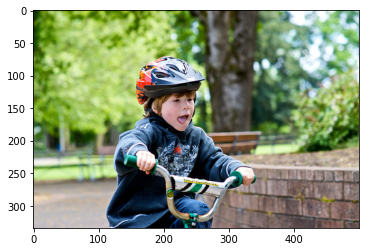

Image with Caption: the boy is wearing red hat and riding bike


In [48]:
# Your result
pic = list(encoding_test.keys())[550]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Image with Caption:",imageSearch(image))